In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import seaborn as sns

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from functions.read_g4bl_data import readDetData

# Location of G4bl output:
dir = 'g4bl-output/'

# Figure directory:
fig_dir = 'figures/'

In [52]:
# Load data for all detectors:
data = readDetData('det.txt')
x = data['x'].values; y = data['y'].values; z = data['z'].values # mm
px = data['px'].values; py = data['py'].values; pz = data['pz'].values; ptotal = data['ptotal'].values # MeV/c
t = data['t'].values # ns
xp = data['xp'].values; yp = data['yp'].values
EventIDs = data['EventID'].values

# Identify unique z values:
unique_z = data.drop_duplicates(subset=['z'])['z']

### Initial and final detectors only

In [53]:
# Isolate data for initial detector:
xi, yi, zi = [], [], []
pxi, pyi, pzi, ptotali = [], [], [], []
ti = []
for i in range(len(x)):
    if z[i] == unique_z[0]:
        xi.append(x[i])
        yi.append(y[i])
        zi.append(z[i])
        pxi.append(px[i])
        pyi.append(py[i])
        pzi.append(pz[i])
        ptotali.append(ptotal[i])
        ti.append(t[i])

# Isolate data for final detector:
xf, yf, zf = [], [], []
pxf, pyf, pzf, ptotalf = [], [], [], []
tf = []
for i in range(len(x)):
    if z[i] == unique_z[len(unique_z)-1]:
        xf.append(x[i])
        yf.append(y[i])
        zf.append(z[i])
        pxf.append(px[i])
        pyf.append(py[i])
        pzf.append(pz[i])
        ptotalf.append(ptotal[i])
        tf.append(t[i])

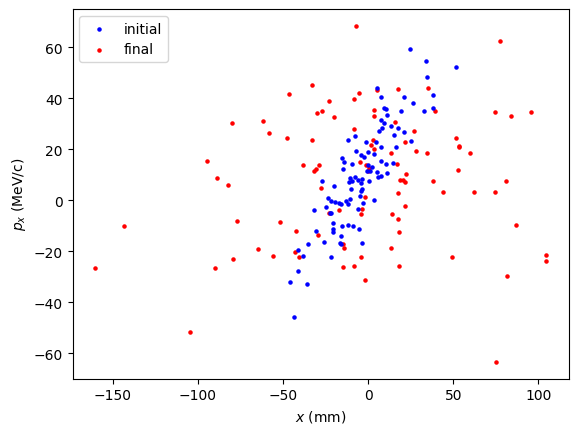

In [54]:
# Plot px vs x:
point_size = 5
plt.scatter(xi,pxi,color='blue',label='initial',s=point_size,zorder=2)
plt.scatter(xf,pxf,color='red',label='final',s=point_size)
plt.xlabel('$x$ (mm)')
plt.ylabel('$p_x$ (MeV/c)')
plt.legend()
plt.show()

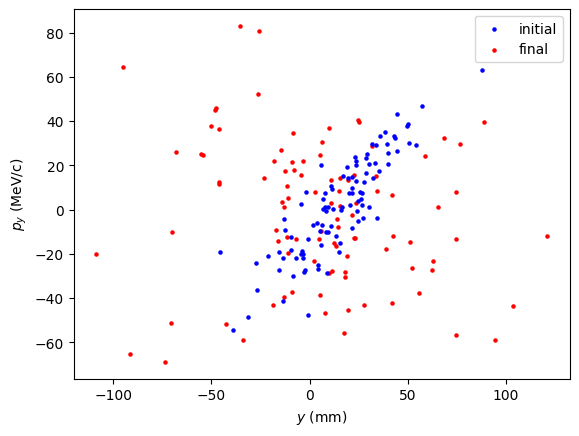

In [55]:
# Plot py vs y:
plt.scatter(yi,pyi,color='blue',label='initial',s=point_size,zorder=2)
plt.scatter(yf,pyf,color='red',label='final',s=point_size)
plt.xlabel('$y$ (mm)')
plt.ylabel('$p_y$ (MeV/c)')
plt.legend()
plt.show()

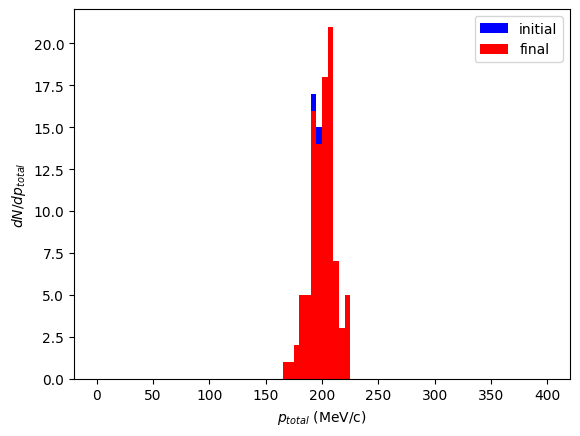

In [56]:
# Plot total p distribution:
nbins = 80
plt.hist(ptotali,color='blue',label='initial',range=(0,400),bins=nbins)
plt.hist(ptotalf,color='red',label='final',range=(0,400),bins=nbins)
plt.xlabel('$p_{total}$ (MeV/c)')
plt.ylabel('$dN/dp_{total}$')
plt.legend()
plt.show()

### All detectors

In [57]:
# Compute transmission rate:
df_unique = data.drop_duplicates(subset=['EventID', 'z'])
counts_by_z = df_unique['z'].value_counts().sort_index()
z0 = data['z'].min()
n_initial = df_unique[df_unique['z'] == z0]['EventID'].nunique()
trans_rate = counts_by_z / n_initial

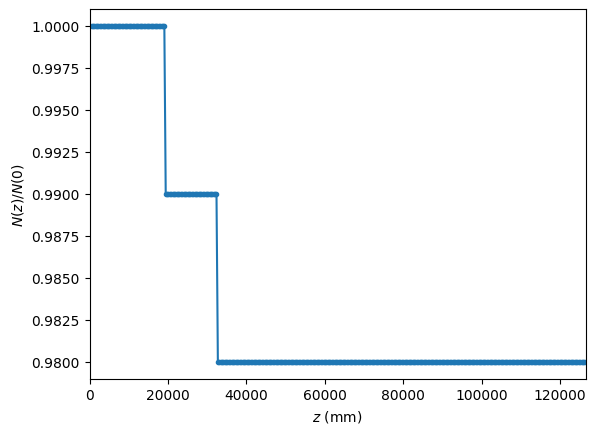

In [60]:
# Plot transmission rate along z:
plt.plot(unique_z, trans_rate, marker='.')
plt.xlim(0,max(unique_z))
plt.xlabel('$z$ (mm)')
plt.ylabel('$N(z)/N(0)$')
plt.show()

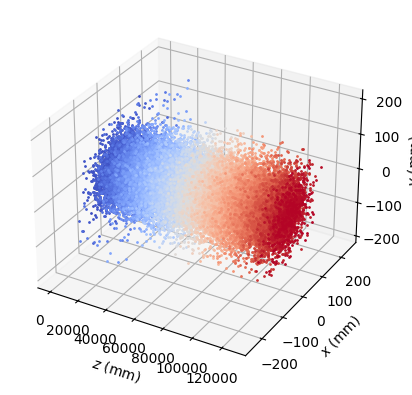

In [59]:
# 3D plot of x, y distribution at each detector:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))
for i in range(len(z)):
    color = cmap(norm(z[i]))
    ax.scatter(z[i],x[i],y[i],color=color,s=1)
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$x$ (mm)')
ax.set_zlabel('$y$ (mm)')
plt.show()

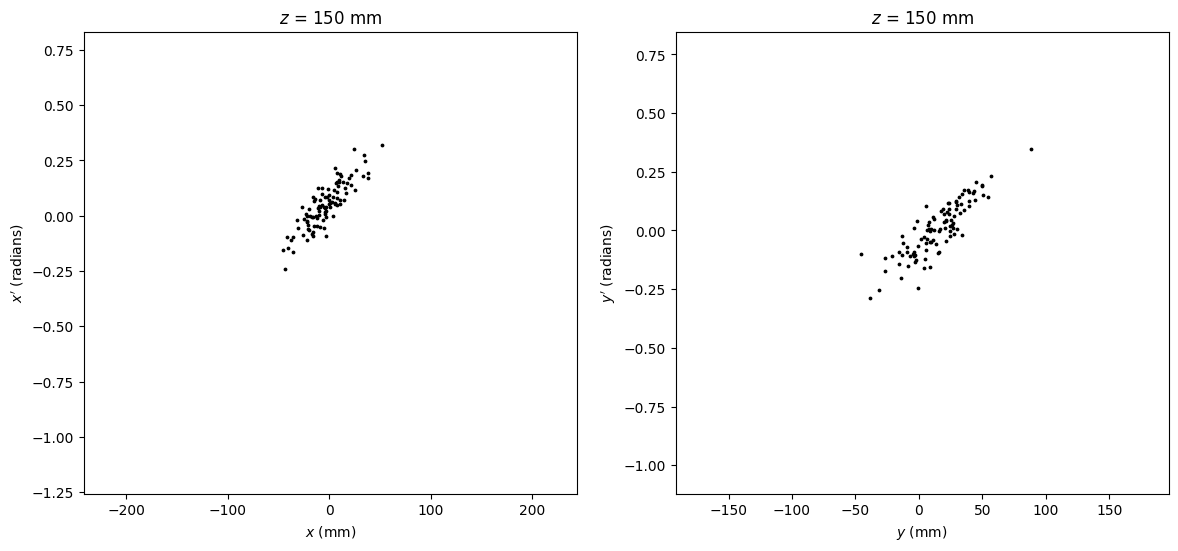

In [61]:
# Animate phase space evolution along z:
unique_z_vals = np.unique(z)
data_by_z1 = []
data_by_z2 = []
for unique_z_val in unique_z_vals:
    # x:
    temp_x = [x_val for x_val, z_val in zip(x, z) if z_val == unique_z_val]
    temp_xp = [xp_val for xp_val, z_val in zip(xp, z) if z_val == unique_z_val]
    data_by_z1.append((temp_x, temp_xp))
    # y:
    temp_y = [y_val for y_val, z_val in zip(y, z) if z_val == unique_z_val]
    temp_yp = [yp_val for yp_val, z_val in zip(yp, z) if z_val == unique_z_val]
    data_by_z2.append((temp_y, temp_yp))
fig, ax = plt.subplots(1,2,figsize = (14,6))
# x:
sc1 = ax[0].scatter([], [], s=3,color='black')
ax[0].set_xlim(np.min(x), np.max(x))
ax[0].set_xlabel('$x$ (mm)')
ax[0].set_ylabel('$x^{\prime}$ (radians)')
title1 = ax[0].set_title("")
ax[0].set_xlim(min(x), max(x))
ax[0].set_ylim(min(xp), max(xp))
# y:
sc2 = ax[1].scatter([], [], s=3,color='black')
ax[1].set_xlim(np.min(y), np.max(y))
ax[1].set_xlabel('$y$ (mm)')
ax[1].set_ylabel('$y^{\prime}$ (radians)')
title2 = ax[1].set_title("")
ax[1].set_xlim(min(y), max(y))
ax[1].set_ylim(min(yp), max(yp))
def update(frame):
    x_val, xp_val = data_by_z1[frame]
    y_val, yp_val = data_by_z2[frame]
    sc1.set_offsets(np.column_stack((x_val, xp_val)))
    sc2.set_offsets(np.column_stack((y_val, yp_val)))
    title1.set_text(f'$z$ = {int(unique_z_vals[frame])} mm')
    title2.set_text(f'$z$ = {int(unique_z_vals[frame])} mm')
ani = FuncAnimation(fig, update, frames=len(unique_z_vals), interval=500, blit=False)
ani.save(fig_dir+'phase_space_subplot_animation.gif', writer='pillow')

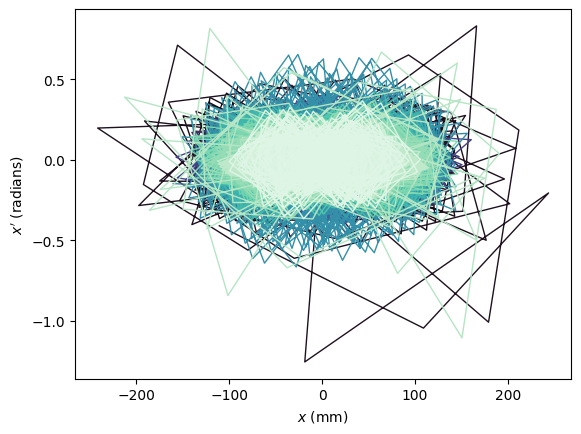

In [62]:
# Subplot phase space (x) trajectory for each event:
nEvents = len(np.unique(EventIDs))
plt.figure()
cmap = sns.color_palette("mako", as_cmap=True)
colors = cmap(np.linspace(0, 1, nEvents))
for j in range(len(np.unique(EventIDs))):
    xp_select_vals = []
    x_select_vals = []
    for i in range(len(z)):
        if EventIDs[i] == j:
            xp_select_vals.append(xp[i])
            x_select_vals.append(x[i])
    plt.plot(x_select_vals,xp_select_vals,color=colors[j],linewidth=1)
plt.xlabel('$x$ (mm)')
plt.ylabel('$x^{\prime}$ (radians)')
plt.show()

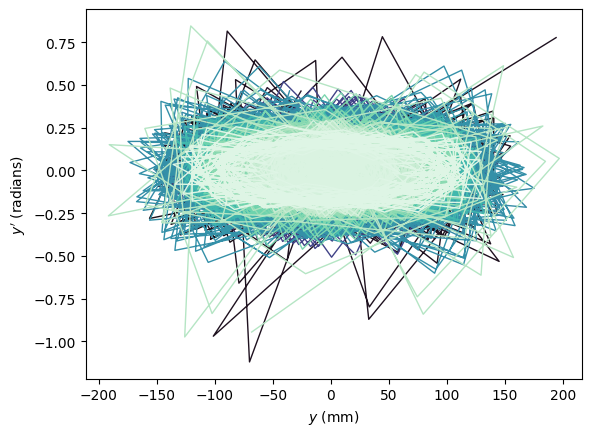

In [63]:
# Subplot phase space (y) trajectory for each event:
plt.figure()
cmap = sns.color_palette("mako", as_cmap=True)
colors = cmap(np.linspace(0, 1, nEvents))
for j in range(len(np.unique(EventIDs))):
    yp_select_vals = []
    y_select_vals = []
    for i in range(len(z)):
        if EventIDs[i] == j:
            yp_select_vals.append(yp[i])
            y_select_vals.append(y[i])
    plt.plot(y_select_vals,yp_select_vals,color=colors[j],linewidth=1)
plt.xlabel('$y$ (mm)')
plt.ylabel('$y^{\prime}$ (radians)')
plt.show()